In [1]:
# Imports for this notebook

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy import ndimage
from ipywidgets import interact, interactive, fixed

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Some util functions, we'll be using
def showGreyImage(im):    
    """Display a grayscale image using pyplot."""
    plt.gray(); # default show grayscale images
    plt.axis("off")
    plt.imshow(im)
    
def surf(Z):
    """Show a surface plot of a 2D matrix, equivalent to Matlab's surf function."""
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    dim = Z.shape;
    X, Y = np.meshgrid(range(0, dim[0]), range(0, dim[1]))

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    plt.show()
        
def surfSubPlots(Z1, Z2):
    """Show 2 surface plots side-by-side."""
    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    Z = Z1;
    dim = Z.shape;
    X, Y = np.meshgrid(range(0, dim[0]), range(0, dim[1]))

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    Z = Z2;
    dim = Z.shape;
    X, Y = np.meshgrid(range(0, dim[0]), range(0, dim[1]))
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
    plt.show()

### Centre-surround receptive fields
[TODO: Some blurb about retinal ganglion cells being centre surround.]

These centre-surround receptive fields can be modelled as a 'difference of Gaussians', which is composed of the difference between two gaussians with different variance. Note that the normalisation constants are important to ensure that the receptive field has no DC component.

$$
D(x, y) = 
\frac{1}{2 \pi \sigma_c ^2}
e^{-\frac{(x^2 + y^2)}{2 \sigma_c ^2}}
-
\frac{1}{2 \pi \sigma_s ^2}
e^{-\frac{(x^2 + y^2)}{2 \sigma_s ^2}}
$$

We implement these below. 

In [3]:
def gaussianField(hsize, sigma):
    """Create a gaussian filter"""
    sigma = float(sigma);
    
    D = np.full(hsize,np.nan);

    c = (hsize-[1,1])/2; # centre pixel, 0-indexing
    Z = (2*np.pi*sigma*sigma);

    for coord in [(x, y) for x in xrange(hsize[0]) for y in xrange(hsize[1])] :
        xy = coord - c;
        D[coord] = np.exp(-(float(xy[0])**2 + float(xy[1])**2)/(2*(sigma**2)))/Z;
    return D;

def DoG(hsize, sigmaCentral, sigmaSurround):
    """Create a difference-of-gaussians filter"""

    H1 = gaussianField(hsize, sigmaCentral);
    H2 = gaussianField(hsize, sigmaSurround);
    return H1 - H2;


Let's take a look at the resulting filter. 
Notice that you can change the relative variances of your gaussian functions to make an on-centre receptive field (sensitive to locally bright patches) or an off-centre responsive field (sensitive to locally dark patches). What happens if you make sigma too large relative to the size of the filter patch? Think about the DC response of the filter.

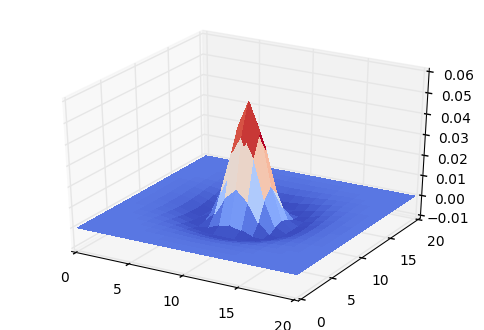

In [4]:
def showDoGfilter(filterWidth = 21, sigmaCentral = 1.5, sigmaSurround = 3.0):
    hsize = np.array((filterWidth,filterWidth));
    H = DoG(np.array((filterWidth, filterWidth)), sigmaCentral, sigmaSurround);
    surf(H);
    
interact(showDoGfilter, filterWidth = fixed(21), sigmaCentral = (0.5, 10.0, 0.1), \
        sigmaSurround = (0.5, 10.0,  0.1));

Suppose you had a cell with a difference-of-gaussian receptive field centred at each pixel in the image. The resulting activity of all the cells can be computed by convolving the filter across the image. Let's see what that looks like for an example image.

Try switching the relative sizes of sigmaCentral and sigmaSurround. What do you see? Does this match up with our intuition for finding bright or dark local patches?

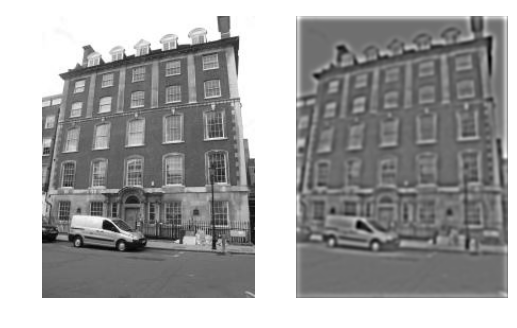

In [5]:
# Load sample image 
image = mpimg.imread("image_sntn_hwk3.bmp").astype(float)
hsize = np.array((21, 21));

def filterImageDoG(image, filterWidth = 21, sigmaCentral = 1.5, sigmaSurround = 3):
    # Convolve image with filter
    H = DoG(hsize, sigmaCentral, sigmaSurround);
    I = ndimage.convolve(image, H, mode='constant')
    
    # Display input and output    
    plt.subplot(121);
    showGreyImage(image);
    plt.subplot(122);
    showGreyImage(I);
    
interact(filterImageDoG, image=fixed(image), filterWidth = fixed(21), \
         sigmaCentral=(0.1, 10, 0.1), sigmaSurround=(0.1, 10, 0.1));

If we apply a threshold to the resulting image, we have a feature detector. What features is the filter detecting? Play with the parameters of the filter and the value of the threshold. The threshold is expressed as a percentile. See if you can tune the parameters to make a good edge detector.


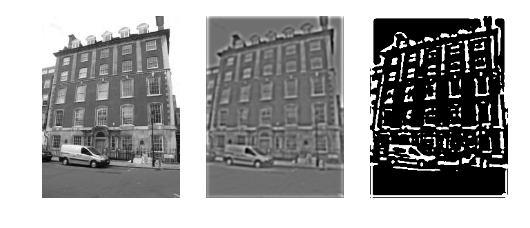

In [6]:
def filterAndThresholdImageDoG(image, filterWidth = 21, \
                               sigmaCentral = 1.5, sigmaSurround = 3, \
                               threshold = 80):
    # Convolve image with filter
    H = DoG(hsize, sigmaCentral, sigmaSurround);
    I = ndimage.convolve(image, H, mode='constant')
    
    # Threshold filtered image
    pixelThresh = np.percentile(I, threshold); 
    I2 = I > pixelThresh;

    # Display input, filtered image, and thresholded output    
    plt.subplot(131);
    showGreyImage(image);
    plt.subplot(132);
    showGreyImage(I);
    plt.subplot(133);
    showGreyImage(I2);

interact(filterAndThresholdImageDoG, image = fixed(image), filterWidth = fixed(21), \
         sigmaCentral=(0.1, 10, 0.1), sigmaSurround=(0.1, 10, 0.1), threshold = (50, 100));

### Orientation-selective receptive fields

You should have seen that the difference-of-gaussians filter can be thought of as an edge detector - it responds to changes in local intensity. However, since the filter is symmetrical, it doesn't tell us anything about the orientation of the edges it finds.

If we consider receptive fields in the mammalian visual system, we find that the visual cortex (area V1) contains cells that are orientation-selective - they respond to changes in spatial intensity only along a specific orientation. These can be modelled by a Gabor filter, which is a Gaussian modulated by a cosine wave - defined by the following equation:
$$
d(\overrightarrow{x}) = 
exp\{ 
- \frac{ (\overrightarrow{k} (\theta) \cdot \overrightarrow{x})^{2}}{2\sigma _{l} ^{2}} 
- \frac{(\overrightarrow{k}\bot(\theta) \cdot \overrightarrow{x})^{2}}{2\sigma _{w} ^{2}}\}
\cos({2 \pi \frac{(\overrightarrow{k}_{\bot} \cdot \overrightarrow{x})}{\lambda} + \phi})
$$

$\overrightarrow{k}$ is a unit vector with the orientation $\theta$, $\overrightarrow{k}\bot(\theta)$ is an orthogonal unit vector, and $\theta$, $\sigma_{x}$, $\sigma_w$, $\lambda$ and $\psi$ parameterise the Gabor.

In [7]:
def Gabor(hsize, sigmaL, sigmaW, lam, theta, phi):
    D = np.full(hsize,np.nan);
    
    centre = (hsize-[1,1])/2; # centre pixel, 0-indexing
    
    k = np.array((np.cos(theta), np.sin(theta)));
    k_orth = np.array((-np.sin(theta), np.cos(theta)));
    
    for coord in [(x, y) for x in xrange(hsize[0]) for y in xrange(hsize[1])] :

        xy = coord - centre;

        xy = xy.astype(float);
        if (np.linalg.norm(xy) > 0):
            xhat = x/np.linalg.norm(x)

        e = -((np.dot(k, xy)**2)/(2*(sigmaL**2))) - ((np.dot(k_orth, xy)**2)/(2*(sigmaW**2)));
        c = 2*np.pi*(np.dot(k_orth, xy)/lam) + phi;
        D[coord] = np.exp(e)*np.cos(c);        

    return D

Let's take a look at the shape of the Gabor filter for a range of parameter values. How does each variable affect the shape of the Gabor?

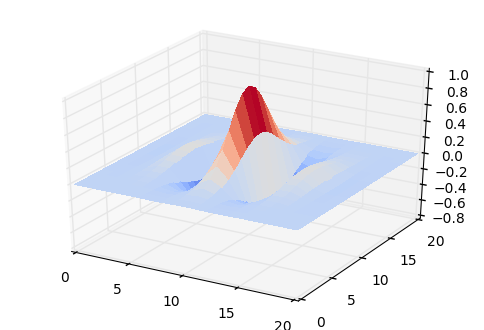

In [8]:
def showGaborFilter(filterWidth = 21, sigmaL = 3, sigmaW = 3, lam = 6, theta = 0, phi = 0):
    hsize = np.array((filterWidth,filterWidth));
    H = Gabor(hsize, sigmaL, sigmaW, lam, theta, phi);
    surf(H);
    
interact(showGaborFilter, filterWidth = fixed(21), theta=(0, 2*np.pi, 2*np.pi/36), \
                          sigmaL = (0.1, 10, 0.1), sigmaW = (0.1, 10, 0.1), \
                          lam = (1, 10), phi = (0, 2*np.pi, 2*np.pi/36), \
                          continuous_update=False);

Hopefully you should have been able to verify the following effects:
* $\sigma_l$ determines the gaussian width in the preferred orientation
* $\sigma_w$ determines the gaussian width perpendicular to the preferred orientation
* $\lambda$ determines the spatial frequency of the cosine modulation
* $\theta$ determines the preferred orientation, rotating the filter in x-y.
* $\phi$ introduces a phase offset to the modulation, which results in a non-symmetric filter

Let's see what happens when we apply this filter to the same image and threshold the results:

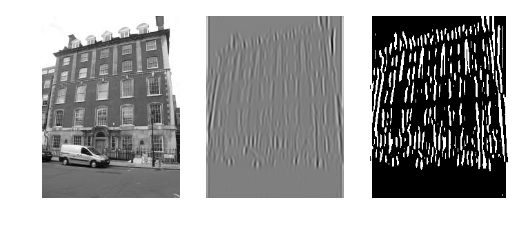

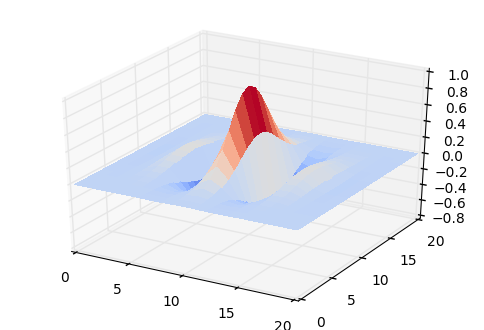

In [9]:
def filterAndThresholdImageGabor(image, filterWidth = 21,\
                                 sigmaL = 3, sigmaW = 3, lam = 6, \
                                 theta = 0, phi = 0, threshold = 80):

    # Create Gabor filter
    H = Gabor(np.array((filterWidth, filterWidth)), sigmaL, sigmaW, lam, theta, phi);

    # Apply filter
    I = ndimage.convolve(image, H, mode='constant');  
    
    # Threshold filtered image
    pixelThresh = np.percentile(I, threshold); 
    I2 = I > pixelThresh;
    
    # Show results
    plt.subplot(131);
    showGreyImage(image);
    plt.subplot(132);
    showGreyImage(I);
    plt.subplot(133);
    showGreyImage(I2);
    
    # Plot filter, for reference
    surf(H);

interact(filterAndThresholdImageGabor, image = fixed(image), filterWidth = fixed(21), \
         sigmaL = (0.1, 10, 0.1), sigmaW = (0.1, 10, 0.1), \
         lam = (1, 10), phi = (0, 2*np.pi, 2*np.pi/36), \
         theta=(0, 2*np.pi, 2*np.pi/36), threshold = (50, 100), \
         continuous_update=False);

#### Formalising response functions
So far we have looked at empirical results for the response of Gabor filters on an example image. To consider the response function more formally, we consider the case where the stimulus is a (static) cosine grating as shown in various orientations here:

<img src="gratings.png">

The stimulus is comprised of an oriented cosine function.
$$
s(x, y) = cos(a cos(\phi)x +
a sin(\phi)y - \psi)
$$
where $a$ and $b$ determine the spatial frequency, and $\psi$ determines the phase offset.

To compute the response of a Gabor to this stimulus, we note that the response is given by a convolution of the Gabor and the stimulus:
$$
o(x, y) = \int_x \int_y h(x, y) s^{*}(x, y) dx dy
$$

Parseval's theorem tells us that this dot product in the spatial domain can be converted directly to a similar dot product in the Fourier domain, which will give us a simpler computation:
$$
o(x, y) = \int_{-\infty} ^{\infty} h(x)s^{*}(x) dx = \int_{-\infty} ^{\infty} H(\omega)S^{*}(\omega) d\omega
$$

Before we get into any further maths, let's take a look at the Fourier transforms involved.

#### Fourier transform of a cosine
A cosine is comprised of a single frequency. Its Fourier transform is comprised of two delta functions, at $\pm \omega_{0}$. If the cosine is defined in a 2D space, then the two delta functions are located at $(\omega_{x}, \omega_{y})$ and  $(-\omega_{x}, -\omega_{y})$. If $\omega_{x}$ and $\omega_{y}$ are given by $a cos(\phi)$ and $a sin(\phi)$ then changing $\phi$ rotates the two delta functions around the Z axis. Let's take a look below.

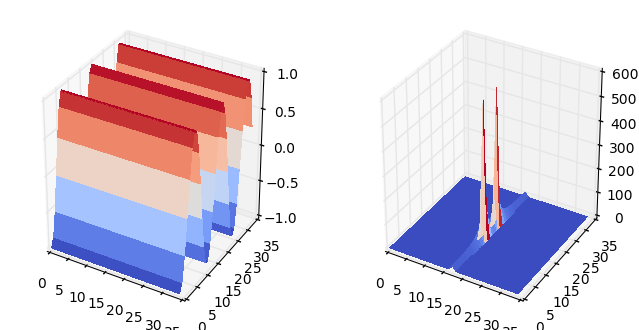

In [10]:
def cosineGrating(hsize, a = 6, phi = np.pi, psi=0):
    """Create a static cosine grating"""
    D = np.full(hsize,np.nan);
    
    centre = (hsize-[1,1])/2; # centre pixel, 0-indexing
    for coord in [(x, y) for x in xrange(hsize[0]) for y in xrange(hsize[1])] :
        #xy = coord.astype(float);
        D[coord] = np.cos(a*np.cos(phi)*coord[0] + a*np.sin(phi)*coord[1] - psi);

    return D

# FFT of a cosine stimulus
def cosineFft(a, phi, psi):    
    H = cosineGrating(np.array((35, 35)), a, phi, psi);    
    surfSubPlots(H, np.abs(np.fft.fftshift(np.abs(np.fft.fft2(H)))))
    
interact(cosineFft, a = (0.1, 1.0, 0.1), phi=(0, 2*np.pi, np.pi/10), \
         psi = (0, 2*np.pi, np.pi/10), continuous_update=False);


#### Fourier transform of a Gaussian
The Fourier transform of a Gaussian is also a Gaussian, but with the inverse covariance. Think about the frequencies required to make a Gaussian - a thin peaky distribution requires more high frequencies than a short fat one.  

$$
f(x) \propto e^{-\frac{x^{2}}{2\sigma^{2}}}
$$
$$
F(\omega) \propto e^{\frac{-\omega^{2}\sigma^{2}}{2}}
$$

#### Fourier transform of a Gabor
A Gabor function is comprised of a Gaussian multiplied by a cosine. By the convolution theorem, a multiplication in the spatial domain corresponds to a convolution in the frequency domain - that is, a gaussian convolved with two delta functions. If you convolve any distribution with a delta function, you end up with a copy of the original distribution translated to the location of the delta functions. With this in mind, we can see that the Fourier transform of a Gabor is two Gaussian distributions, located at ($\omega_x, \omega_y$) and (-$\omega_x, -\omega_y$). Let's take a look.

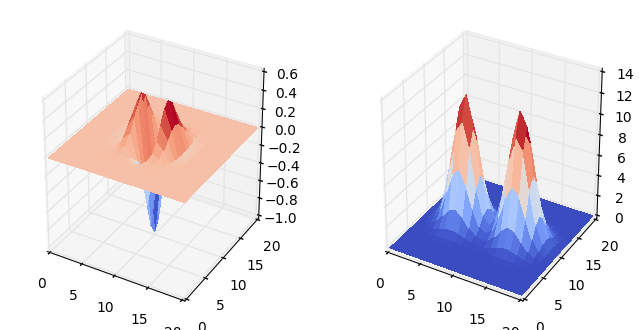

In [11]:
def gaborFft(theta, sigma_x, sigma_y, lam, psi):    
    H = Gabor(np.array((21, 21)), sigma_x, sigma_y, lam, theta, psi);
    surfSubPlots(H, np.fft.fftshift(np.abs(np.fft.fft2(H))));
    
interact(gaborFft, theta=(0, 2*np.pi, np.pi/10), sigma_x=(0, 5, 0.5), \
         sigma_y=(0, 5, 0.5), lam = (1, 10), psi=(0, 2*np.pi, np.pi/10));

Now we know what the gabor filter and the cosine grating look like in the Fourier domain, we can think about what happens when we convolve them to compute the response. Delta functions act as a 'sieve' under integration, so the convolution of a Gaussian with a delta function is equivalent to evaluating the Gaussian at the point given by the delta function. To get some intuition for how the output depends on various parameters, let's plot the Fourier transform of the Gabor and overlay the position of the delta functions. The response of the filter will be proportional to the height of the Gaussians at this position.

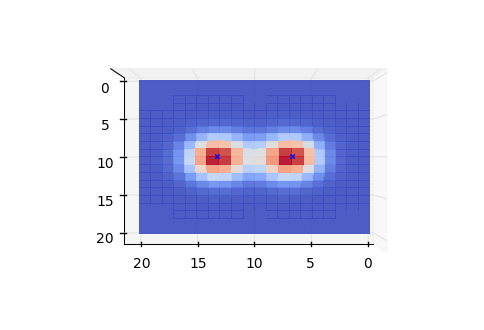

In [12]:
def displayGaborAndStimFourier(sigma_x = 2, sigma_y = 2, theta_gabor = 0, theta_grating = 0):
    lam = 7;
    H = Gabor(np.array((21, 21)), sigma_x, sigma_y, lam, theta_gabor, 0);
    H_f = np.fft.fftshift(np.abs(np.fft.fft2(H)));

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    dim = H_f.shape;
    X, Y = np.meshgrid(range(0, dim[0]), range(0, dim[1]))
    
    # Display 
    surf = ax.plot_surface(X, Y, H_f, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha=0.9)

    # For stimulus, compute position of delta function directly to avoid quantisation over grid.
    # Stimulus is fixed to have same spatial frequency as gabor.
    omega = lam/2;
    x = omega*np.array((np.cos(theta_grating), -np.cos(theta_grating)));
    y = omega*np.array((-np.sin(theta_grating), np.sin(theta_grating)));
    z = np.array((np.max(H_f)*1.2, np.max(H_f)*1.2));
    centre = np.subtract(np.shape(H),(1,1))/2;

    ax.scatter(centre[0]+x, centre[1]+y, z, s=10, marker='x');
    
    # View everything from above
    ax.azim = 90;
    ax.elev = 90;
    ax.set_xlim([0, 21])
    ax.set_ylim([0, 21])
    ax.set_zticks([])
    plt.show();
    
interact(displayGaborAndStimFourier, sigma_x = (0.5, 5, 0.5), sigma_y = (0.5, 5, 0.5), 
         theta_gabor = (0, 2*np.pi, 0.1), theta_grating = (0, 2*np.pi, 0.1), \
         continuous_update=False);


Let's compute the resulting values and plot them against $\theta$. This tells us the orientation-sensitivity of the filter. What variables do you need to change to make the filter's orientation response more or less wide?